# MM20B007 - Assignment 3

In [1]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import requests
import os
import shutil
from bs4 import BeautifulSoup
import mlflow

## Download Function

In [ ]:
for i in range(2023, 2024):

  print(f'The year is {i}')
  url = f'https://www.ncei.noaa.gov/data/local-climatological-data/access/{i}/'

  response = requests.get(url)

  if response.status_code == 200:
      
      soup = BeautifulSoup(response.content, 'html.parser')

      
      links = soup.find_all('a')
      links.reverse()
      print(f'THe number of csv files are - {len(links)}')

      # Directory to save the CSV files
      save_dir = r"D:\sem 8\CS5830\Assignment 4\downloaded_csvs"
      temp_dir = r"D:\sem 8\CS5830\Assignment 4\temp_csvs"
      os.makedirs(save_dir, exist_ok=True)
      os.makedirs(temp_dir, exist_ok=True)

      i = 1

      for link in links:
        print(f'The csv file number is {i}')

        href = link.get('href')

        if href and href.endswith('.csv'):
            # Build the full URL to the CSV file
            csv_url = url + href

            # Send a GET request to download the CSV file
            csv_response = requests.get(csv_url)

            # Temporarily save the CSV file if the request was successful
            if csv_response.status_code == 200:
                temp_csv_path = os.path.join(temp_dir, href)
                with open(temp_csv_path, 'wb') as f:
                    f.write(csv_response.content)

                df = pd.read_csv(temp_csv_path, low_memory = False)

                if df['DailyDepartureFromNormalAverageTemperature'].notna().any() and df['MonthlyDepartureFromNormalAverageTemperature'].notna().any():
                    # Move the file to the permanent directory
                    final_csv_path = os.path.join(save_dir, href)
                    shutil.move(temp_csv_path, final_csv_path)
                    print(f'Downloaded and verified {href}')
                    print('\n')
                else:
                    # Delete the file if it doesn't meet the criteria
                    os.remove(temp_csv_path)
                    print(f'Does not satisfy the requirements')
                    print('\n')
            else:
                print(f'Failed to download {href}')
                print('\n')

        if i >= 50:
          break
        else:
          i += 1
  else:
      print('Failed to access the website')
      print('\n')

In [14]:
files = []
for dirname, _, filenames in os.walk(save_dir):
    for filename in filenames:
        path = str(os.path.join(dirname, filename))
        files.append(path)

## Prepare Function

In [5]:
def prepare_data(file_path):

  # Read the file
  data = pd.read_csv(file_path, low_memory=False)

  # Converting the values to numeric to ensure smooth calculation
  data['DailyDepartureFromNormalAverageTemperature'] = pd.to_numeric(data['DailyDepartureFromNormalAverageTemperature'], errors='coerce')

  filtered_data = data[['DATE', 'DailyDepartureFromNormalAverageTemperature']].copy()
  filtered_data['DATE'] = pd.to_datetime(filtered_data['DATE'])

  # Caculating the monthly aggregate for the feature
  monthly_aggregates = filtered_data.groupby(filtered_data['DATE'].dt.to_period('M'))['DailyDepartureFromNormalAverageTemperature'].mean().reset_index()
  monthly_aggregates['DATE'] = monthly_aggregates['DATE'].dt.to_timestamp()
  monthly_aggregates.columns = ['Month', 'MonthlyAvgDeparture']

  return monthly_aggregates

## Process Function

In [6]:
def process_data(file_path):

  # Read the file
  data = pd.read_csv(file_path, low_memory=False)

  # calcualting the monthly data for the feature
  monthly_data = data[['DATE', 'MonthlyDepartureFromNormalAverageTemperature']].copy()
  monthly_data['DATE'] = pd.to_datetime(monthly_data['DATE'])

  # The monthly data should be processed throughly for the further calculation. The information is being grouped as per months
  processed_monthly_aggregates = monthly_data.groupby(monthly_data['DATE'].dt.to_period('M'))['MonthlyDepartureFromNormalAverageTemperature'].mean().reset_index()
  processed_monthly_aggregates['DATE'] = processed_monthly_aggregates['DATE'].dt.to_timestamp()
  processed_monthly_aggregates.columns = ['Month', 'GivenMonthlyAvgDeparture']

  return processed_monthly_aggregates

## Evaluate Function

In [7]:
def r2(prepared_data, processed_data):

  # R2 score is caluclated with the help of this function without relying on the sklearn library
  comparison_df = pd.merge(prepared_data, processed_data, on='Month', how='inner')

  comparison_df_clean = comparison_df.dropna(subset=['MonthlyAvgDeparture', 'GivenMonthlyAvgDeparture']).copy()

  ss_res = ((comparison_df_clean['MonthlyAvgDeparture'] - comparison_df_clean['GivenMonthlyAvgDeparture']) ** 2).sum()

  mean_of_actuals = comparison_df_clean['MonthlyAvgDeparture'].mean()
  ss_tot = ((comparison_df_clean['MonthlyAvgDeparture'] - mean_of_actuals) ** 2).sum()

  r2 = 1 - (ss_res / ss_tot)

  comparison_df_clean['R2_Score'] = r2

  return comparison_df_clean, r2

In [12]:
def evaluate_data(files, PLOT = True):

  r2_scores = {}
  common_path = 'D:\\sem 8\\CS5830\\Assignment 4\\downloaded_csvs\\'

  # The r2 score is calculated for each file that contain data is calculated here
  for file_path in files:

    file_name = file_path.replace(common_path, '')

    prepared_data = prepare_data(file_path)
    processed_data = process_data(file_path)

    prepared_data = pd.DataFrame(data = prepared_data)
    processed_data = pd.DataFrame(data = processed_data)

    evaluation_result, r2_score = r2(prepared_data, processed_data)
    r2_scores[file_name] = r2_score

    mlflow.log_metric("r2_score", r2_score)

  if PLOT == True:
    plt.plot(r2_scores.keys(), r2_scores.values())
    plt.xlabel('CSV files')
    plt.ylabel('R2 score')
    plt.xticks(rotation = 45)
    plt.title('R2 score for each file')
    plt.savefig("R2_score.png")
    mlflow.log_artifact("R2_score.png")
    plt.show()

  return r2_scores

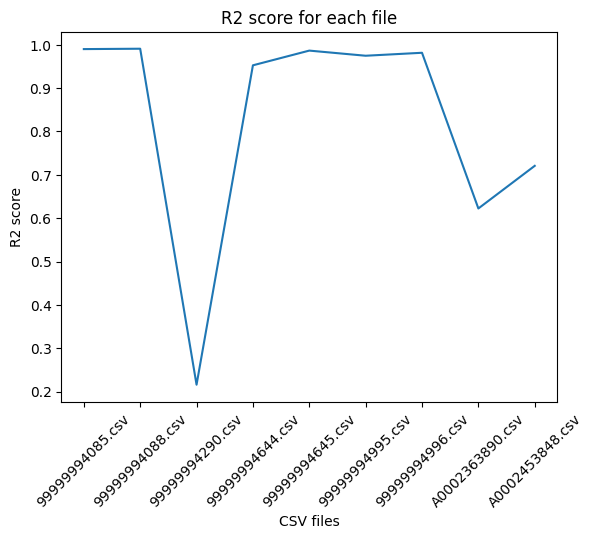

R^2 Score: {'99999994085.csv': 0.9900001013724198, '99999994088.csv': 0.9908640198588946, '99999994290.csv': 0.21580359236503766, '99999994644.csv': 0.9525832900449271, '99999994645.csv': 0.986517720091041, '99999994995.csv': 0.9746794156032483, '99999994996.csv': 0.9815185080289853, 'A0002363890.csv': 0.6223639693548368, 'A0002453848.csv': 0.7207068469350111}
Model run:  2ad10c29db4e4401b1687e796077ad85


In [15]:
# The mlflow setup
mlflow.set_experiment("Dataset Consistency Verification Experiment")

with mlflow.start_run():
    r2_score = evaluate_data(files)
    print("R^2 Score:", r2_score)
    print("Model run: ", mlflow.active_run().info.run_uuid)
mlflow.end_run()